Alexander S. Lundervold, November 6th, 2019.

***Under construction***

# Introduction

This notebook and the next is meant to give you a taste of neural networks and deep learning. This is a very large field and the taste will be small. The goal is to perhaps satisfy some of your curiosity ("What is deep learning? How do you *do* deep learning") and point you towards ways to learn more about the topic.

We'll see how to construct a basic deep neural network in PyTorch, and how to train it to perform a task. 

To get a better understanding of what neural networks are and how they work, I recommend watching the following two videos. They give a nice high-level understanding. To learn more about the details, see the references listed on Canvas. 

In [42]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/aircAruvnKk" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

In [43]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/IHZwWFHWa-w" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

## Convolutional neural networks

Then we'll construct what's called a *convolutional neural network*, the best kind of neural network for images (and more, see the lecture slides for details). 

In [44]:
%%HTML
<video width=60% autoplay loop> <source src="assets/CNN-viz-otavio-good.mp4"> </video>

We won't cover how CNNs work in any detail, but the lecture will give some motivation for why one would want to do CNNs rather than standard fully-connected neural networks. 

For more about how CNNs work, I recommend watching the video below. It gives a nice high-level introduction to convolutional neural networks. For more in-depth understanding consult the references listed on Canvas. 

In [45]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/FmpDIaiMIeA" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import shutil
import zipfile
import os

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

In addition to our standard framework imported above, we'll need both torch and torchvision:

*If you have problems importing these, see https://github.com/alu042/DAT158ML for troubleshooting tips, or ask Alexander or a TA for assistance.*

In [4]:
import sys
!conda install --yes --prefix {sys.prefix} -c pytorch pytorch torchvision

Solving environment: done

# All requested packages already installed.



In [5]:
import torch
import torchvision
import torch.nn.functional as F

# A simple example

We'll use a famous benchmark data set, widely studied by the computer vision community: <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Cifar-10</a>. 

It consists of 60.000 32x32 color images from 10 different classes:

<img src="assets/cifar10.png">

The goal is to create a system that can recognize what's in each image. That is, an **image classifier**. 

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

There are 50.000 training images and 10.000 test images. 

## Loading the data into PyTorch

PyTorch (and other deep learning frameworks) operate on what's called **tensors**, which are essentially multidimensional arrays that can be placed on GPUs for accellerated computing. 

To process the Cifar-10 images we need to convert them to tensors:

### Data loaders

`utils.py` contains the code used to download the images, normalize them (to improve neural network performance), convert them into tensors, and create data loaders for PyTorch. Take a look if you're curious. 

In [7]:
from utils import get_cifar10, plot_cifar10

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainloader, testloader = get_cifar10(batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


### Plot some images

Here are a few images and labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


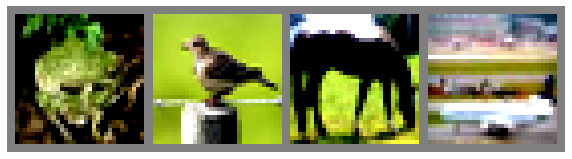

['frog', 'bird', 'horse', 'plane']


In [9]:
plot_cifar10()

# Simple neural networks (in PyTorch)

As we discussed in the lecture, there are two stages to training a neural network: a forward pass to get values for all the nodes between the input and output, and a backward pass where backpropagation (automatic differentiation and dynamic programming) and gradient descent is used to tweak all the weights in the network. 

To make gradient descent work, we need to be able to take the derivative of each component in the network (these derivatives are computed during backpropagation). 

For details about these procedures, see http://cs231n.github.io/optimization-2. 

Luckily PyTorch can take care of the differentiation for us (that is, the backward pass) if we create a network inheriting from `nn.Module`:

## A fully-connected neural net in PyTorch

Here's a simple one hidden layer neural network in PyTorch:

In [10]:
input_size = 32*32*3 # The Cifar-10 images are 32x32 with three color channels
hidden_size = 84 # We can choose this number

In [11]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        
        super(Net, self).__init__()
        
        # A hidden layer
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        
        # An output layer
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)
        
    # We need to define what we want to happen in the forward phase (the backward phase is automatic)
    
    def forward(self, x):
        
        # Make the 32x32x3 image into a 32*32*3 = 3072 vector
        x = x.view(x.size(0), -1) 
        
        # Feed the input vector through the hidden layer and an activation function
        x = torch.tanh(self.fc1(x)) 
        
        # Output num_classes of numbers.
        # We'll train the network to output a high number for the correct class
        x = self.fc2(x) 
        
        return x

In [12]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes)

In [13]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

## Training the network

Remember the steps:
1. Define a neural network (DONE)
2. Collect a batch of training data (we'll use our trainloader)
3. Send these through the network to get its predictions
4. Measure the discrepancy between the true labels and the predictions using a loss function
5. Update all the weights using backpropagation (to calculate the gradients) and gradient descent (to update the weights)

### Training the network on a single batch

#### First, lets take a look at a batch

In [14]:
# Get the next batch
i, data = next(enumerate(trainloader, 0))

We've now collected the first batch of 4 images:

In [15]:
i

0

In [16]:
images, labels = data

In [17]:
len(images), len(labels)

(4, 4)

The labels of the first four are:

In [18]:
labels

tensor([1, 9, 6, 8])

...which means that the images are of

In [19]:
[classes[label] for label in labels]

['car', 'truck', 'frog', 'ship']

The images are torch tensors:

In [20]:
images.shape

torch.Size([4, 3, 32, 32])

Four images (batch size), 3 color channels, images of size 32x32. 

#### Feeding the batch to the network

In [21]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

Computing the output of the network from these images is simple:

In [22]:
outputs = net(images)

In [23]:
outputs.shape

torch.Size([4, 10])

As expected, we got four vectors of length 10. Our goal is to make the element in each vector that corresponds to the correct label for the images in the batch as large as possible, while the rest are small. 

Since we haven't trained our network at all yet, we can't expect it to produce any good predictions:

In [24]:
_, predicted = torch.max(outputs.data, 1)

In [25]:
predicted

tensor([7, 1, 4, 4])

In [26]:
labels

tensor([1, 9, 6, 8])

Chances are none of the predictions are correct. This is because we've initialized the network with random weights. 

#### Loss function

To measure the discrepancy between the output and the actual labels, we'll use our good friend, **cross entropy loss**. 

Have a look back to Part 2 to remind yourself about cross entropy. The lecture will also give you a recap of the function (when relating neural networks to softmax regression). For another quick explanation, have a look at https://www.youtube.com/watch?v=ErfnhcEV1O8.

In [27]:
criterion = torch.nn.CrossEntropyLoss()

Let's calculate the loss for our current batch: 

In [28]:
loss = criterion(outputs, labels)

In [29]:
loss

tensor(2.2377, grad_fn=<NllLossBackward>)

#### Backpropagation

Using the `backward` method PyTorch can calculate how much each weight in the network contributed to the loss by calculating the gradient of the loss with respect to each of them (using a technique called automatic differentation, which is related to the chain rule you know from MAT108):

In [30]:
loss.backward()

#### Gradient descent

Now we can update all the weights using stochastic gradient descent:

In [31]:
learning_rate = 0.01

In [32]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

Take one step with the optimizer to modify each weight:

In [33]:
optimizer.step()

The network has now been trained *a tiny bit* (it has learned from the first four images). 

Let's see if that helped:

In [34]:
outputs = net(images)

In [35]:
_, predicted = torch.max(outputs.data, 1)

In [36]:
predicted

tensor([1, 9, 6, 8])

In [37]:
labels

tensor([1, 9, 6, 8])

The network improved (on these four images on which it trained..). 

> **Your turn!** Feed the next batch to the network and check how it performs on those. Not well...

### Going through the training data, batch by batch

The idea now is to repeat this batch by batch, until we've been through the entire training data set multiple times. The idea is that gradient descent will then be able to find good settings for all the weights, and we can use those when new data is fed through the network. 

Let's first create a simple function for checking the accuracy of the network on the test data:

In [38]:
def check_accuracy(net, dataloader=testloader):
        correct = 0
        total = 0
        
        # Feed all the test data through the net and count the number of correct predictions:
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        
        accuracy = correct.numpy() / total
            
        print('The accuracy of the network on the 10.000 test images is: %d %%' % (100 * accuracy))
        
        return accuracy

Our current accuracy after training on a single batch is

In [39]:
_ = check_accuracy(net)

The accuracy of the network on the 10.000 test images is: 12 %


Since the network is essentially untrained this is as expected (randomly guessing among the 10 classes gives an accuracy of 10%).

Here's the entire procedure for feeding batches through the network. You can CTRL+ENTER this cell to run it multiple times. You'll see the accuracy improve.

In [40]:
learning_rate = 0.001

In [41]:
# Get next batch
i, data = next(enumerate(trainloader, 0))
images, labels = data
# A technicality: we have to zero out the gradients each time, 
# otherwise they'll accumulate
optimizer.zero_grad()
# Collect the outputs
outputs = net(images)
# Compute the loss
loss = criterion(outputs, labels)
print(f'Current loss: {loss}')
# Compute the gradients of the loss with respect to all the weights
loss.backward()
# Update the weights using gradient descent
optimizer.step()
# Compute the current accuracy
_ = check_accuracy(net)

Current loss: 2.673748731613159
The accuracy of the network on the 10.000 test images is: 13 %


> **Question:** How many times do you have to run the above cell to go through the entire training data set once? 

Let's make a loop!

#### Training loop

We'll go through the entire training set 1 time. Feel free to increase this (but it'll take quite some time as we're running on the CPU, not the GPU [for now]).

In [42]:
num_epochs = 1

In [43]:
# We record the accuracies during training for later analysis
accuracies = [check_accuracy(net), ]

for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            
            acc = check_accuracy(net)
            
            print("-"*40)
            accuracies.append(acc)
            running_loss = 0.0

print('Training complete')

The accuracy of the network on the 10.000 test images is: 13 %
[1,  1000] loss: 1.954
The accuracy of the network on the 10.000 test images is: 35 %
----------------------------------------
[1,  2000] loss: 1.856
The accuracy of the network on the 10.000 test images is: 36 %
----------------------------------------
[1,  3000] loss: 1.818
The accuracy of the network on the 10.000 test images is: 36 %
----------------------------------------
[1,  4000] loss: 1.841
The accuracy of the network on the 10.000 test images is: 37 %
----------------------------------------
[1,  5000] loss: 1.794
The accuracy of the network on the 10.000 test images is: 36 %
----------------------------------------
[1,  6000] loss: 1.796
The accuracy of the network on the 10.000 test images is: 37 %
----------------------------------------
[1,  7000] loss: 1.788
The accuracy of the network on the 10.000 test images is: 36 %
----------------------------------------
[1,  8000] loss: 1.785
The accuracy of the netwo

We can plot the accuracy changes during training:

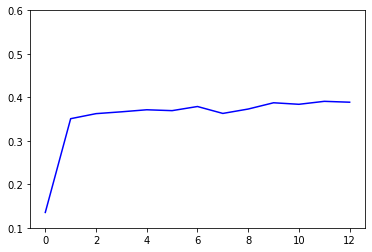

In [44]:
plt.ylim([0.1, 0.6])
plt.plot(accuracies, 'b')
plt.show()

We see that we quickly reach what seems to be a plateau in accuracy. We need something else to go beyond 40%...

**That's it**, basically! Now you know the basics of training neural networks!

However, our above neural network is not particularly powerful. We can do much, much better...

> **Your turn!** Try adding a second hidden layer to the network. How does it influence performance? Try experimenting with the sizes of the hidden layers. Are you able to obtain a better result than above?

> Note: if you remove the "check_accuracy" call in the training loop it'll speed up the training.

# *More content will be added*

- A **convolutional neural network** architecture
- Another example based on a **a different data set**

**Next notebook:** The state-of-the-art in deep learning.